LSTM & GRU Time Series Analysis - Johnson & Johnson

        date  data
0 1960-01-01  0.71
1 1960-04-01  0.63
2 1960-07-02  0.85
3 1960-10-01  0.44
4 1961-01-01  0.61


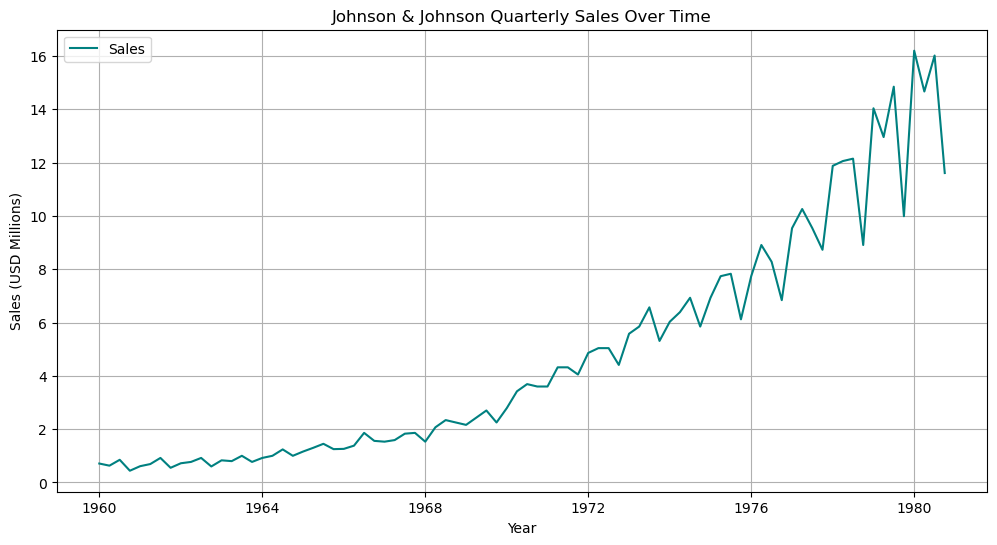

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
import matplotlib.pyplot as plt

#Load and Plot the Data
data = pd.read_csv("jj.csv", parse_dates=['date'])
print(data.head())

sales_col = 'data'  # Adjust if your column name is different

# Plot raw sales data
plt.figure(figsize=(12,6))
plt.plot(data['date'], data[sales_col], label="Sales", color="teal")
plt.title("Johnson & Johnson Quarterly Sales Over Time")
plt.xlabel("Year")
plt.ylabel("Sales (USD Millions)")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
# Preprocess and Create Sequences
sales_data = data[[sales_col]].values
dates = data['date']

# Train-test split (95% train)
training_data_len = int(len(sales_data) * 0.95)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(sales_data)

# Create sliding windows
window_size = 4  # 4 quarters (1 year)
X_train, y_train = [], []

for i in range(window_size, training_data_len):
    X_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


In [3]:
# Build LSTM and GRU Models
def build_model_lstm():
    model = keras.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        keras.layers.LSTM(64, return_sequences=False),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

def build_model_gru():
    model = keras.Sequential([
        keras.layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        keras.layers.GRU(64, return_sequences=False),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

# Train Both Models
lstm_model = build_model_lstm()
gru_model = build_model_gru()

lstm_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)
gru_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)


C:\Users\rkkro\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6486 - root_mean_squared_error: 0.8139
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4973 - root_mean_squared_error: 0.6458 
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2345 - root_mean_squared_error: 0.3305 
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1987 - root_mean_squared_error: 0.2712 
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1820 - root_mean_squared_error: 0.2319 
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1543 - root_mean_squared_error: 0.2423 
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1505 - root_mean_squared_error: 0.1993 
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1344 - root_mean_squared_error: 0.2128 
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1556 - root_mean_squared_error: 0.2195 
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - root_mean_squared_error: 0.1854 


In [4]:
# Forecast Next 24 Months (Recursive Prediction)
# Start with last window of known data
last_window = scaled_data[-window_size:].reshape(1, window_size, 1)

# Forecast 24 quarters = 6 years (change to 8 quarters = 2 years if needed)
forecast_steps = 8  # for 24 months = 8 quarters

def forecast_future(model, last_seq, steps):
    preds_scaled = []
    current_seq = last_seq.copy()
    
    for _ in range(steps):
        pred = model.predict(current_seq)[0][0]
        preds_scaled.append(pred)
        current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)
    
    return scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1))

lstm_future = forecast_future(lstm_model, last_window, forecast_steps)
gru_future = forecast_future(gru_model, last_window, forecast_steps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [5]:
# Generate Future Dates
last_date = data['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')


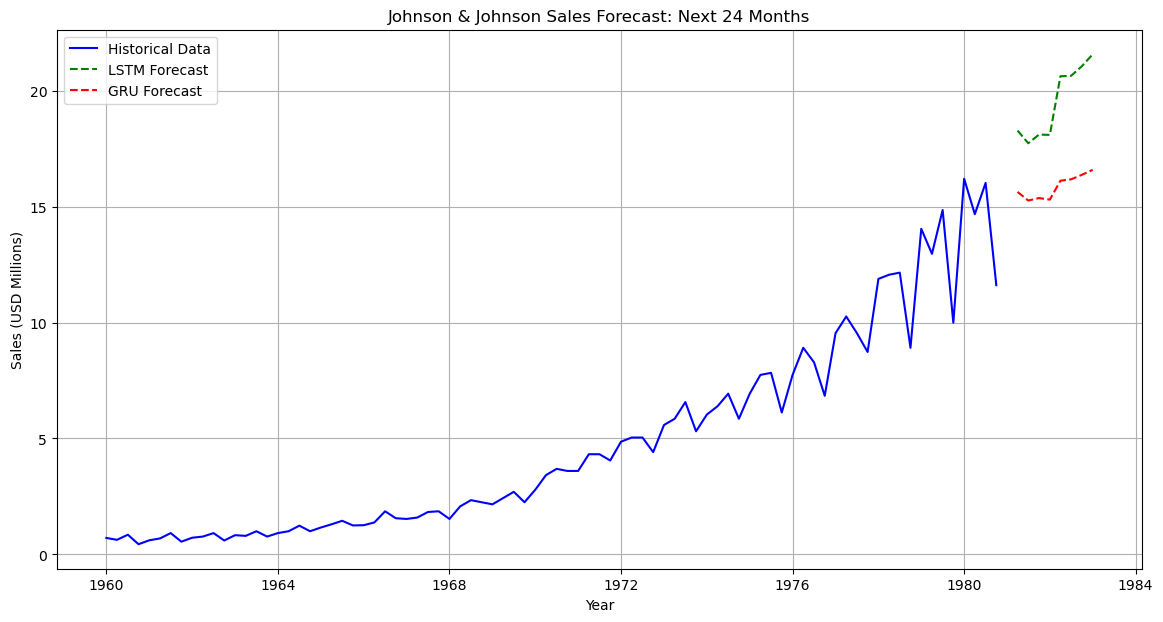

In [6]:
# Plot Forecasts (Future Only)
plt.figure(figsize=(14,7))
plt.plot(data['date'], data[sales_col], label='Historical Data', color='blue')
plt.plot(future_dates, lstm_future, label='LSTM Forecast', color='green', linestyle='--')
plt.plot(future_dates, gru_future, label='GRU Forecast', color='red', linestyle='--')
plt.title('Johnson & Johnson Sales Forecast: Next 24 Months')
plt.xlabel('Year')
plt.ylabel('Sales (USD Millions)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Print Predicted Values
future_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Predicted_Sales': lstm_future.flatten(),
    'GRU_Predicted_Sales': gru_future.flatten()
})
print(future_df)


        Date  LSTM_Predicted_Sales  GRU_Predicted_Sales
0 1981-03-31             18.276234            15.629995
1 1981-06-30             17.728634            15.258868
2 1981-09-30             18.103247            15.365216
3 1981-12-31             18.088882            15.298037
4 1982-03-31             20.617287            16.114264
5 1982-06-30             20.636909            16.173317
6 1982-09-30             21.050953            16.368984
7 1982-12-31             21.567682            16.582918


In [8]:
# Prepare Test Set & Predict
# Prepare test data
test_data = scaled_data[training_data_len - window_size:]
X_test = []
y_test_actual = sales_data[training_data_len:]  # unscaled ground truth

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])

X_test = np.array(X_test).reshape(-1, window_size, 1)

# Predict on test data
lstm_test_preds_scaled = lstm_model.predict(X_test)
gru_test_preds_scaled = gru_model.predict(X_test)

# Inverse scale
lstm_test_preds = scaler.inverse_transform(lstm_test_preds_scaled)
gru_test_preds = scaler.inverse_transform(gru_test_preds_scaled)

# Compute Performance Metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

lstm_rmse, lstm_mae, lstm_mape = calculate_metrics(y_test_actual, lstm_test_preds)
gru_rmse, gru_mae, gru_mape = calculate_metrics(y_test_actual, gru_test_preds)

print("Performance on Test Data:")
print(f"LSTM → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.2f}%")
print(f"GRU  → RMSE: {gru_rmse:.2f}, MAE: {gru_mae:.2f}, MAPE: {gru_mape:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Performance on Test Data:
LSTM → RMSE: 2.81, MAE: 2.12, MAPE: 18.65%
GRU  → RMSE: 2.48, MAE: 2.16, MAPE: 17.84%


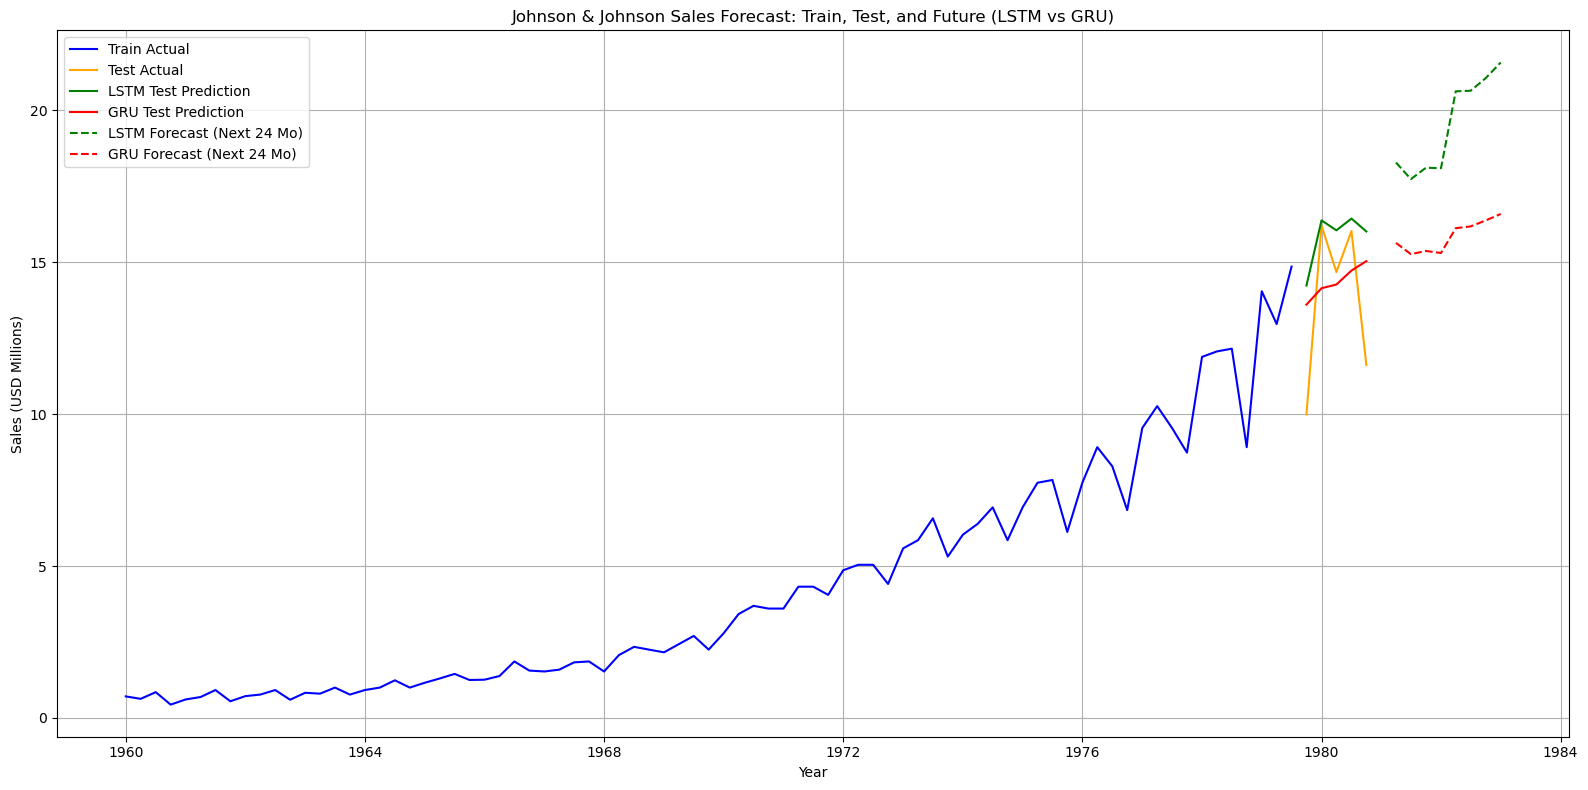

In [9]:
# Combine and Plot All (Train + Test + Future Forecast)
# Historical
train_dates = data['date'][:training_data_len]
test_dates = data['date'][training_data_len:]

# Future forecast dates already generated earlier as `future_dates`

plt.figure(figsize=(16,8))

# Plot training actual
plt.plot(train_dates, sales_data[:training_data_len], label='Train Actual', color='blue')

# Plot test actual & predictions
plt.plot(test_dates, y_test_actual, label='Test Actual', color='orange')
plt.plot(test_dates, lstm_test_preds, label='LSTM Test Prediction', color='green')
plt.plot(test_dates, gru_test_preds, label='GRU Test Prediction', color='red')

# Plot future forecasts
plt.plot(future_dates, lstm_future, label='LSTM Forecast (Next 24 Mo)', color='green', linestyle='--')
plt.plot(future_dates, gru_future, label='GRU Forecast (Next 24 Mo)', color='red', linestyle='--')

plt.title('Johnson & Johnson Sales Forecast: Train, Test, and Future (LSTM vs GRU)')
plt.xlabel('Year')
plt.ylabel('Sales (USD Millions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ARIMA Time Series Analysis - Johnson & Johnson

In [10]:
# Import Required Libraries
from statsmodels.graphics.tsaplots import plot_pacf as pacf_plot, plot_acf as acf_plot
from statsmodels.tsa.arima.model import ARIMA as ArimaModel
from statsmodels.tsa.stattools import adfuller as adf_test
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

            JJ_Sales
date                
1960-01-01      0.71
1960-04-01      0.63
1960-07-02      0.85
1960-10-01      0.44
1961-01-01      0.61
Dataset Dimensions: (84, 1)


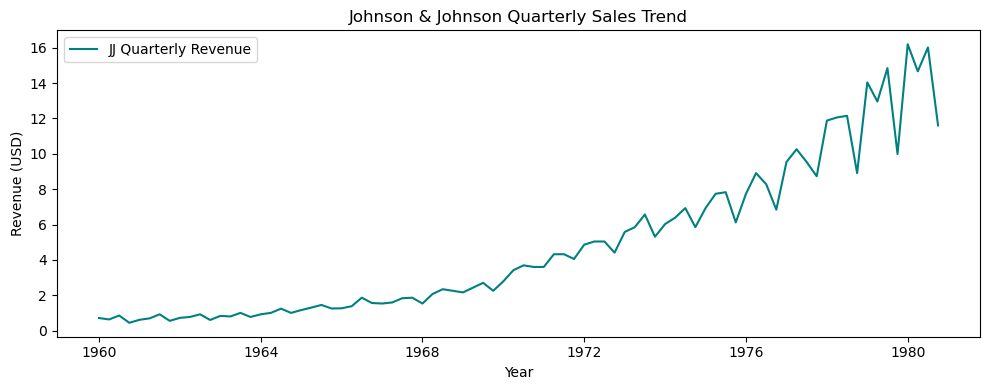

In [11]:
# Load and Prepare the Dataset
jj_data = pd.read_csv('jj.csv', parse_dates=['date'])
jj_data.set_index('date', inplace=True)
jj_data.rename(columns={'data': 'JJ_Sales'}, inplace=True)

print(jj_data.head())
print("Dataset Dimensions:", jj_data.shape)

# Visualize the Original Sales Data
plt.figure(figsize=(10, 4))
plt.plot(jj_data.index, jj_data['JJ_Sales'], color='teal', label='JJ Quarterly Revenue')
plt.title('Johnson & Johnson Quarterly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Revenue (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Stationarity Check using ADF Test
adf_result = adf_test(jj_data['JJ_Sales'])
print(f"\nADF Statistic (Original): {adf_result[0]:.3f}")
print(f"p-value (Original): {adf_result[1]:.3f}")


ADF Statistic (Original): 2.742
p-value (Original): 1.000


In [13]:
# Apply Log Transformation and Differencing
log_series = np.log(jj_data['JJ_Sales'])
log_diff_series = log_series.diff().dropna()

In [14]:
# ADF Test after Transformation
adf_post_diff = adf_test(log_diff_series)
print(f"\nADF Statistic (Log-Diff): {adf_post_diff[0]:.3f}")
print(f"p-value (Log-Diff): {adf_post_diff[1]:.4f}")



ADF Statistic (Log-Diff): -4.317
p-value (Log-Diff): 0.0004


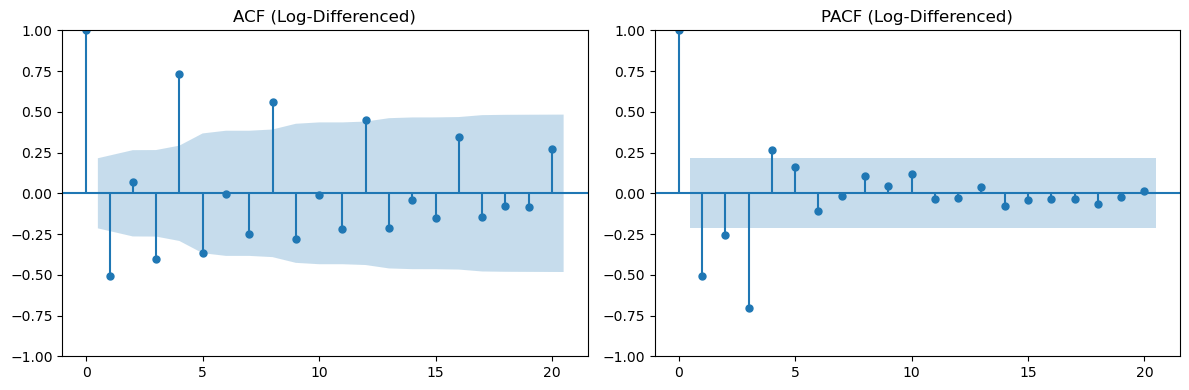

In [15]:
# ACF & PACF Plots for Transformed Series
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
acf_plot(log_diff_series, lags=20, ax=plt.gca())
plt.title('ACF (Log-Differenced)')
plt.subplot(1, 2, 2)
pacf_plot(log_diff_series, lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF (Log-Differenced)')
plt.tight_layout()
plt.show()

In [16]:
from pmdarima import auto_arima

# Automatically find the best ARIMA model
auto_model = auto_arima(
    log_series,
    seasonal=False,        # Set to True if your data has clear seasonal cycles
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",  # ignore if model fails
    trace=True,             # set to True to print model progress
    max_p=6,
    max_d=2,
    max_q=6
)

# Summary and selected order
print("\nBest ARIMA Model Summary:")
print(auto_model.summary())
best_arima_order = auto_model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-78.453, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.362, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.954, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-69.000, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20.234, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-79.831, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-76.900, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-69.390, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-84.515, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-85.908, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-149.459, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-151.150, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-147.539, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-149.3

In [17]:
# Fit the final ARIMA model using statsmodels for compatibility with the rest of your pipeline
final_model = sm.tsa.arima.ARIMA(log_series, order=best_arima_order)
final_result = final_model.fit()
print("\nFitted ARIMA model summary:")
print(final_result.summary())



Fitted ARIMA model summary:
                               SARIMAX Results                                
Dep. Variable:               JJ_Sales   No. Observations:                   84
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  59.608
Date:                Sun, 15 Jun 2025   AIC                           -107.215
Time:                        18:01:23   BIC                            -92.702
Sample:                             0   HQIC                          -101.385
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0319      0.069    -14.906      0.000      -1.168      -0.896
ar.L2         -0.9736      0.080    -12.244      0.000      -1.129      -0.818
ar.L3         -0.8681  

In [18]:
# In-Sample Evaluation Metrics
fitted_pred = final_result.get_prediction(start=log_series.index[0])
log_predicted = fitted_pred.predicted_mean
sales_predicted = np.exp(log_predicted)

actual_vals = jj_data.loc[log_predicted.index, 'JJ_Sales']

mae_val = mean_absolute_error(actual_vals, sales_predicted)
mse_val = mean_squared_error(actual_vals, sales_predicted)
rmse_val = np.sqrt(mse_val)
mape_val = np.mean(np.abs((actual_vals - sales_predicted) / actual_vals)) * 100

print("\nIn-Sample Performance Metrics:")
print(f"MAE: {mae_val:.2f}")
print(f"MSE: {mse_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAPE: {mape_val:.2f}%")



In-Sample Performance Metrics:
MAE: 0.40
MSE: 0.38
RMSE: 0.62
MAPE: 9.44%


In [19]:
# Forecasting Function
def run_arima_forecast(fit_model, steps_ahead, forecast_start):
    forecast_outcome = fit_model.get_forecast(steps=steps_ahead)
    pred_mean_log = forecast_outcome.predicted_mean
    pred_interval_log = forecast_outcome.conf_int()

    forecast_vals = np.exp(pred_mean_log)
    lower_bounds = np.exp(pred_interval_log.iloc[:, 0])
    upper_bounds = np.exp(pred_interval_log.iloc[:, 1])

    future_index = pd.date_range(start=forecast_start, periods=steps_ahead, freq='Q')
    forecast_vals.index = future_index
    lower_bounds.index = future_index
    upper_bounds.index = future_index

    return forecast_vals, lower_bounds, upper_bounds

# Forecast for Next 8 Quarters
future_steps = 8
forecast_start_date = '1981-01-01'
future_forecast, ci_lower, ci_upper = run_arima_forecast(final_result, future_steps, forecast_start_date)

print("\nForecasted Sales:")
print(future_forecast)
print("\nLower CI Bound:")
print(ci_lower)
print("\nUpper CI Bound:")
print(ci_upper)



Forecasted Sales:
1981-03-31    16.707142
1981-06-30    14.968970
1981-09-30    15.556321
1981-12-31    12.130936
1982-03-31    16.614686
1982-06-30    14.797641
1982-09-30    15.235786
1982-12-31    12.594593
Freq: Q-DEC, Name: predicted_mean, dtype: float64

Lower CI Bound:
1981-03-31    13.338127
1981-06-30    11.470554
1981-09-30    11.537267
1981-12-31     8.985327
1982-03-31    11.468417
1982-06-30     9.983192
1982-09-30    10.068049
1982-12-31     8.297136
Freq: Q-DEC, Name: lower JJ_Sales, dtype: float64

Upper CI Bound:
1981-03-31    20.927120
1981-06-30    19.534372
1981-09-30    20.975429
1981-12-31    16.377769
1982-03-31    24.070260
1982-06-30    21.933886
1982-09-30    23.056026
1982-12-31    19.117895
Freq: Q-DEC, Name: upper JJ_Sales, dtype: float64


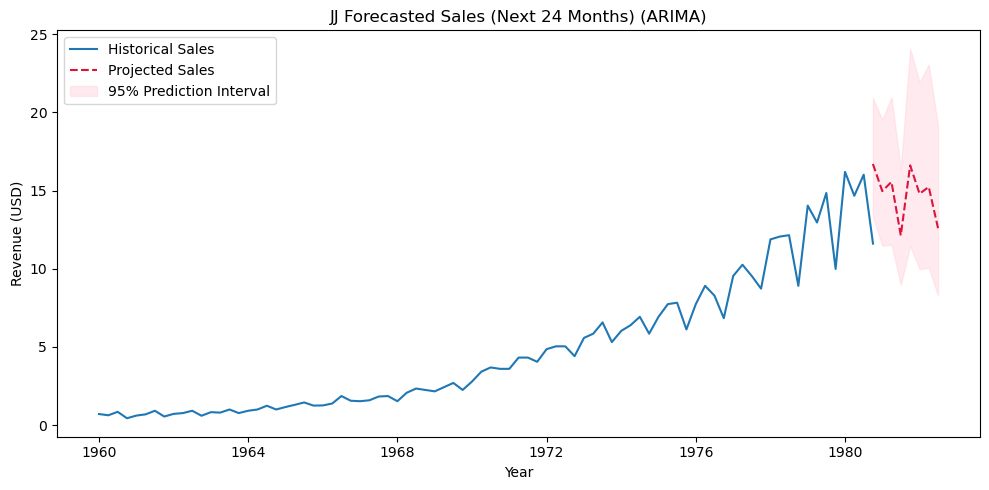

In [36]:
# Forecast Plot vs Original Sales
forecast_plot_index = pd.date_range(start='1980-08-01', periods=8, freq='Q')

plt.figure(figsize=(10, 5))
plt.plot(jj_data.index, jj_data['JJ_Sales'], label='Historical Sales')
plt.plot(forecast_plot_index, future_forecast.values, label='Projected Sales', color='crimson', linestyle='--')
plt.fill_between(forecast_plot_index, ci_lower.values, ci_upper.values, color='pink', alpha=0.3,
                 label='95% Prediction Interval')
plt.title('JJ Forecasted Sales (Next 24 Months) (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Revenue (USD)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


ARIMA Time Series Analysis - Amazon

In [21]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

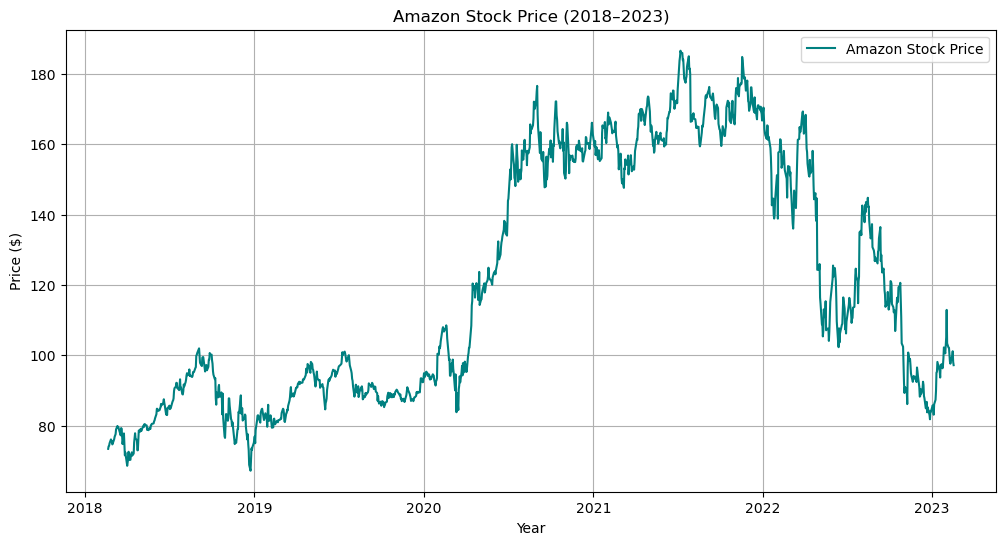

In [22]:
# Load the data
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']].rename(columns={'Close': 'Price'})

# VISUALIZE the data

plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Amazon Stock Price',color = 'teal')
plt.title('Amazon Stock Price (2018–2023)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

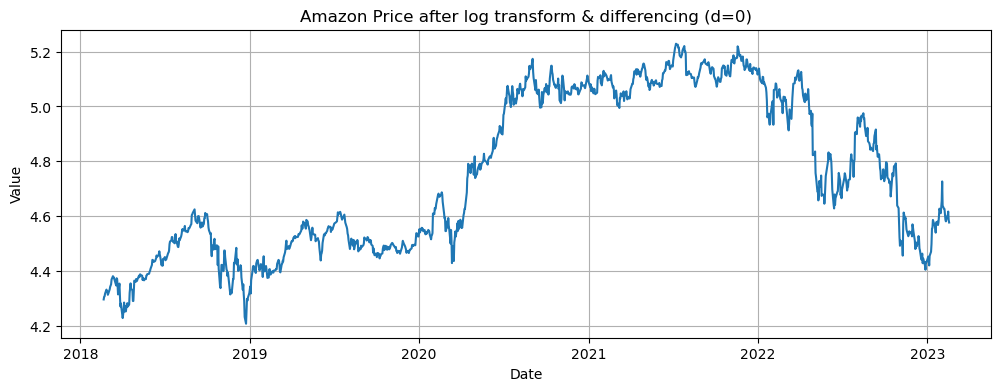

ADF Test (d=0): Test Statistic = -1.7848, p-value = 0.3880
Critical Value (1%): -3.4356
Critical Value (5%): -2.8638
Critical Value (10%): -2.5680
=> Series is still non-stationary, differencing again...



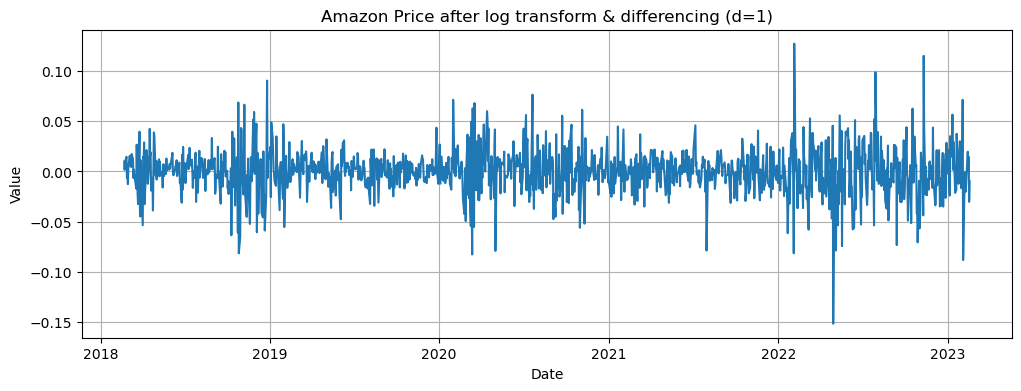

ADF Test (d=1): Test Statistic = -36.6398, p-value = 0.0000
Critical Value (1%): -3.4356
Critical Value (5%): -2.8638
Critical Value (10%): -2.5680
=> Stationary series achieved after differencing 1 times.



In [23]:
# Make stationary
from statsmodels.tsa.stattools import adfuller


def make_stationary(timeseries, max_diff=5, title='Time Series'):
    """
    Apply log transform + differencing until series is stationary (ADF test p-value <= 0.05).
    Plots the series and shows ADF test results at each step.
    Returns stationary series and number of differences applied.
    """
    series = np.log(timeseries)
    diff_count = 0
    
    while diff_count <= max_diff:
        plt.figure(figsize=(12,4))
        plt.plot(series)
        plt.title(f'{title} after log transform & differencing (d={diff_count})')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
        
        adf_result = adfuller(series.dropna())
        print(f"ADF Test (d={diff_count}): Test Statistic = {adf_result[0]:.4f}, p-value = {adf_result[1]:.4f}")
        for key, value in adf_result[4].items():
            print(f"Critical Value ({key}): {value:.4f}")
        
        if adf_result[1] <= 0.05:
            print(f"=> Stationary series achieved after differencing {diff_count} times.\n")
            return series, diff_count
        else:
            print("=> Series is still non-stationary, differencing again...\n")
            series = series.diff()
            diff_count += 1
    
    print(f"Warning: Stationarity not achieved after {max_diff} differences.")
    return series, diff_count


stationary_series, num_diffs = make_stationary(df['Price'], title='Amazon Price')

# Also save the original log-transformed price (for inverse transformation later)
log_price = np.log(df['Price'])



In [24]:
auto_model = auto_arima(log_price, seasonal=False, stepwise=True, suppress_warnings=True)
best_order = auto_model.order
print(f"Best ARIMA order from auto_arima: {best_order}")

model_arima = ARIMA(log_price, order=best_order)
result_arima = model_arima.fit()

Best ARIMA order from auto_arima: (0, 1, 0)


In [25]:
# In-sample prediction
predicted_log = result_arima.predict(start=log_price.index[1])
predicted_price = np.exp(predicted_log)
actual_price = df.loc[predicted_price.index, 'Price']

arima_rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))
arima_mae = mean_absolute_error(actual_price, predicted_price)
arima_mape = np.mean(np.abs((actual_price - predicted_price) / actual_price)) * 100

print("\n🔹 ARIMA In-sample Evaluation:")
print(f"MAE  : {arima_mae:.2f}")
print(f"RMSE : {arima_rmse:.2f}")
print(f"MAPE : {arima_mape:.2f}%")


🔹 ARIMA In-sample Evaluation:
MAE  : 1.92
RMSE : 2.76
MAPE : 1.61%


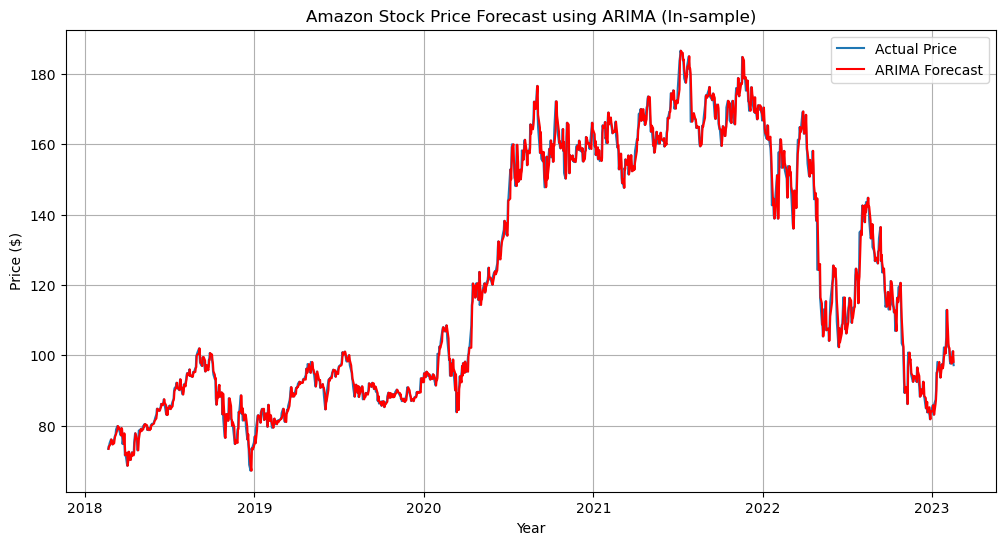

In [26]:
# Plot actual vs predicted (in-sample)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Actual Price')
plt.plot(predicted_price.index, predicted_price, color='red', label='ARIMA Forecast')
plt.title('Amazon Stock Price Forecast using ARIMA (In-sample)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


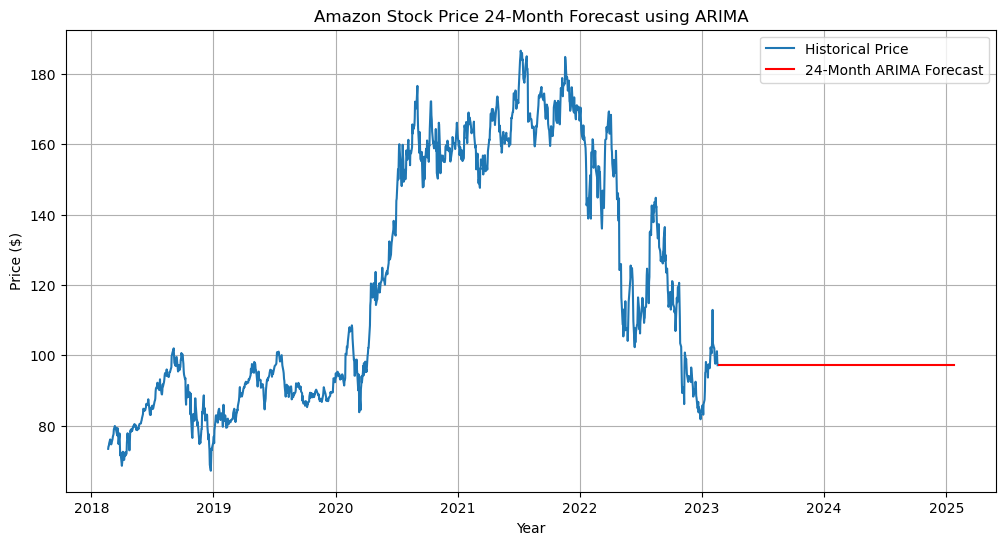

In [27]:
# ARIMA 24-MONTH FORECAST
forecast_steps = 504  # Approx. 2 years of trading days

forecast_log = result_arima.forecast(steps=forecast_steps)
forecast_price = np.exp(forecast_log)

last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
forecast_price.index = future_dates

plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_price, label='24-Month ARIMA Forecast', color='red')
plt.title('Amazon Stock Price 24-Month Forecast using ARIMA')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

LSTM/GRU Time Series Analysis - Amazon

In [28]:
# PREPROCESS FOR LSTM/GRU

# # Normalize price data to the range [0,1] for neural network training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price']])

# Convert time series into sequences (windowed data)
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(scaled_data, time_steps)

# TRAIN-TEST SPLIT
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


LSTM Model Build

In [29]:
# Define a simple LSTM model for regression
model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile the model
model_lstm.compile(optimizer=Adam(0.001), loss='mse')

# Fit model to training data
model_lstm.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# Predict on test data
lstm_pred_scaled = model_lstm.predict(X_test)

# Inverse transform predictions and true values to original scale
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_true_lstm = scaler.inverse_transform(y_test)

#  EVALUATE MODEL
lstm_rmse = np.sqrt(mean_squared_error(y_true_lstm, lstm_pred))
lstm_mae = mean_absolute_error(y_true_lstm, lstm_pred)
lstm_mape = np.mean(np.abs((y_true_lstm - lstm_pred) / y_true_lstm)) * 100

print("\n🔹 LSTM Evaluation:")
print(f"MAE  : {lstm_mae:.2f}")
print(f"RMSE : {lstm_rmse:.2f}")
print(f"MAPE : {lstm_mape:.2f}%")


1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/stepWARNING:tensorflow:5 out of the last 18 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AA9AA1A340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

🔹 LSTM Evaluation:
MAE  : 4.34
RMSE : 5.46
MAPE : 3.73%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

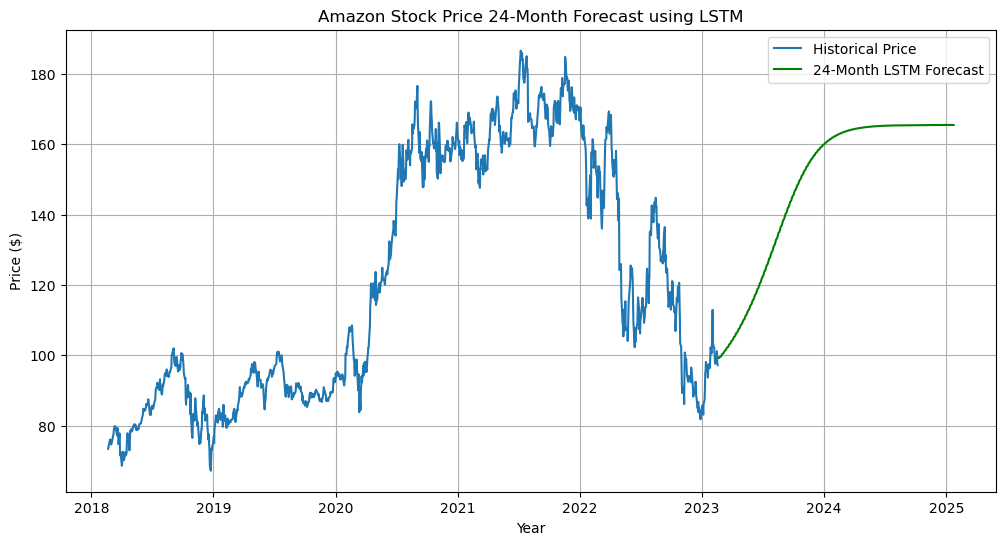

In [30]:
# Forecasting 24 months 
def forecast_lstm(model, last_sequence, steps, scaler):
    """Iteratively forecast future points using LSTM."""
    forecast = []
    current_seq = last_sequence.copy()  # shape: (time_steps, 1)

    for _ in range(steps):
        pred_scaled = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        forecast.append(pred_scaled)
        # Append prediction and remove first element to maintain sequence length
        current_seq = np.append(current_seq[1:], [[pred_scaled]], axis=0)

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_price = scaler.inverse_transform(forecast)
    return forecast_price

# Prepare last sequence from scaled data for prediction
last_sequence = scaled_data[-time_steps:]

forecast_lstm_price = forecast_lstm(model_lstm, last_sequence, forecast_steps, scaler)

# Future dates same as ARIMA forecast
forecast_lstm_index = future_dates

plt.figure(figsize=(12,6))
plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_lstm_index, forecast_lstm_price, label='24-Month LSTM Forecast', color='green')
plt.title('Amazon Stock Price 24-Month Forecast using LSTM')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


GRU Model Build

In [32]:
# Define a simple GRU model architecture for time series prediction
model_gru = Sequential([
    GRU(64, return_sequences=False, input_shape=(X_train.shape[1], 1)),  # 64 GRU units, input = (10, 1)
    Dense(1)  # Output layer predicting a single price
])

# Compile the GRU model with Adam optimizer and Mean Squared Error loss
model_gru.compile(optimizer=Adam(0.001), loss='mse')

# Train the model on training data
model_gru.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

In [33]:
# PREDICT & INVERSE TRANSFORM
# Predict using test data
gru_pred_scaled = model_gru.predict(X_test)

# Inverse transform predicted and true values to original price scale
gru_pred = scaler.inverse_transform(gru_pred_scaled)
y_true_gru = scaler.inverse_transform(y_test)

# EVALUATION METRICS 
gru_rmse = np.sqrt(mean_squared_error(y_true_gru, gru_pred))
gru_mae = mean_absolute_error(y_true_gru, gru_pred)
gru_mape = np.mean(np.abs((y_true_gru - gru_pred) / y_true_gru)) * 100

# Print evaluation results
print("\n🔹 GRU Evaluation:")
print(f"MAE  : {gru_mae:.2f}")
print(f"RMSE : {gru_rmse:.2f}")
print(f"MAPE : {gru_mape:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

🔹 GRU Evaluation:
MAE  : 3.54
RMSE : 4.50
MAPE : 3.04%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

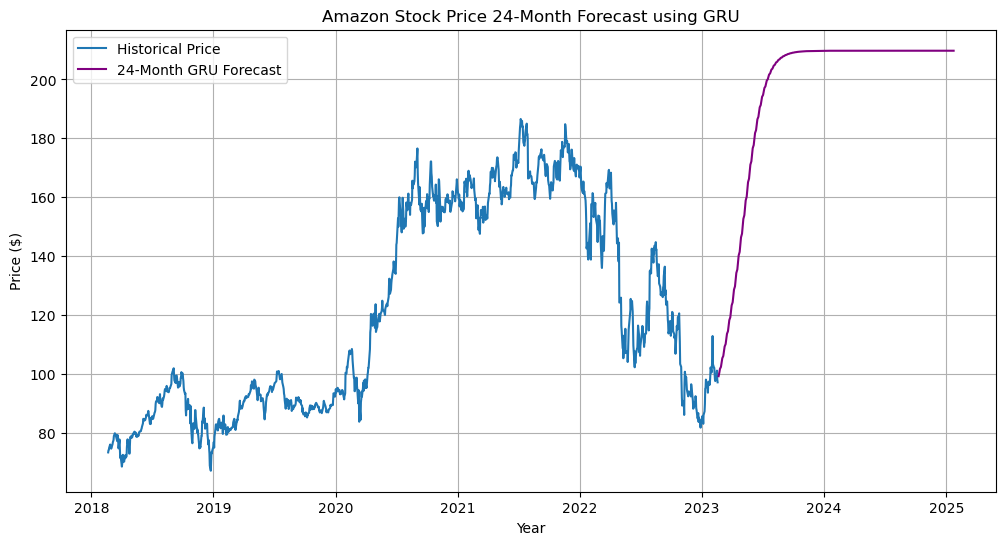

In [34]:
# DEFINE FUTURE FORECAST FUNCTION
# Function to forecast N future steps using the trained GRU model
def forecast_gru(model, last_sequence, steps, scaler):
    forecast = []
    current_seq = last_sequence.copy()  # Start with the last known sequence

    for _ in range(steps):
        # Predict next step
        pred_scaled = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        forecast.append(pred_scaled)

        # Slide the window forward by one step
        current_seq = np.append(current_seq[1:], [[pred_scaled]], axis=0)

    # Inverse scale the full forecast to original price
    forecast = np.array(forecast).reshape(-1, 1)
    forecast_price = scaler.inverse_transform(forecast)
    return forecast_price
# MAKE 24-MONTH FORECAST

forecast_gru_price = forecast_gru(model_gru, last_sequence, forecast_steps, scaler)
forecast_gru_index = future_dates  # Dates for the forecast

# PLOT FUTURE FORECAST 
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_gru_index, forecast_gru_price, label='24-Month GRU Forecast', color='purple')
plt.title('Amazon Stock Price 24-Month Forecast using GRU')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()
